In [1]:
# class VisionTransformer(nn.Module):
#     """Vision Transformer as per https://arxiv.org/abs/2010.11929."""

#     def __init__(
#         self,
#         image_size: int,
#         patch_size: int,
#         num_layers: int,
#         num_heads: int,
#         hidden_dim: int,
#         mlp_dim: int,
#         dropout: float = 0.0,
#         attention_dropout: float = 0.0,
#         num_classes: int = 1000,
#         representation_size: Optional[int] = None,
#         norm_layer: Callable[..., torch.nn.Module] = partial(nn.LayerNorm, eps=1e-6),
#         conv_stem_configs: Optional[List[ConvStemConfig]] = None,
#     ):
import torchvision
from torchvision.models import VisionTransformer
import torch
import torchvision.transforms as transforms
from replacer import replace_linears_in_pytorch_model
from bitnet158 import BitLinear158B
import math

In [2]:
transform = transforms.Compose(
    [torchvision.transforms.Grayscale(num_output_channels=3),
     transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

# Create datasets for training & validation, download if necessary
training_set = torchvision.datasets.MNIST('./data', train=True, transform=transform, download=True)
validation_set = torchvision.datasets.MNIST('./data', train=False, transform=transform, download=True)

# Create data loaders for our datasets; shuffle for training, not for validation
training_loader = torch.utils.data.DataLoader(training_set, batch_size=4, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=4, shuffle=False)

print('Training set has {} instances'.format(len(training_set)))
print('Validation set has {} instances'.format(len(validation_set)))

Training set has 60000 instances
Validation set has 10000 instances


(32, 122)


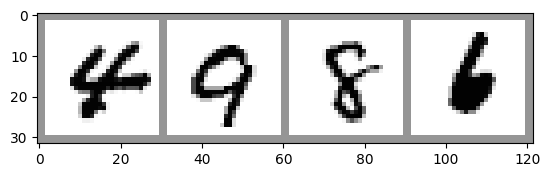

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    print(npimg.shape)
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(training_loader)
images, labels = next(dataiter)

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)

In [7]:
#model = VisionTransformer(image_size=28, patch_size=4, num_layers=8, num_heads=2, hidden_dim=1024, mlp_dim=2048, num_classes=10)
model = VisionTransformer(image_size=28, patch_size=4, num_layers=4, num_heads=2, hidden_dim=20, mlp_dim=20, num_classes=10)

In [5]:
loss_fn = torch.nn.CrossEntropyLoss()

# NB: Loss functions expect data in batches, so we're creating batches of 4
# Represents the model's confidence in each of the 10 classes for a given input
dummy_outputs = torch.rand(4, 10)
# Represents the correct class among the 10 being tested
dummy_labels = torch.tensor([1, 5, 3, 7])

print(dummy_outputs)
print(dummy_labels)

loss = loss_fn(dummy_outputs, dummy_labels)
print('Total loss for this batch: {}'.format(loss.item()))

tensor([[0.0855, 0.0572, 0.8516, 0.8469, 0.8856, 0.2716, 0.1229, 0.1822, 0.8401,
         0.1057],
        [0.7339, 0.8309, 0.6936, 0.8730, 0.1006, 0.2502, 0.3082, 0.8046, 0.9776,
         0.3407],
        [0.7330, 0.2695, 0.5288, 0.0896, 0.8581, 0.1871, 0.8165, 0.2474, 0.5771,
         0.3944],
        [0.6164, 0.9046, 0.3616, 0.3308, 0.5370, 0.0726, 0.9725, 0.4090, 0.9741,
         0.5671]])
tensor([1, 5, 3, 7])
Total loss for this batch: 2.6614456176757812


In [6]:
# Optimizers specified in the torch.optim package
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [7]:
def train_one_epoch(epoch_index):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs, labels = data

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(training_loader) + i + 1
            #add wandb
            #tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

In [8]:
# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
epoch_number = 0

EPOCHS = 1

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number)


    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, vdata in enumerate(validation_loader):
            vinputs, vlabels = vdata
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # # Log the running loss averaged per batch
    # # for both training and validation
    # writer.add_scalars('Training vs. Validation Loss',
    #                 { 'Training' : avg_loss, 'Validation' : avg_vloss },
    #                 epoch_number + 1)
    # writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)

    epoch_number += 1

EPOCH 1:
  batch 1000 loss: 2.056946685731411
  batch 2000 loss: 1.7297265878021717
  batch 3000 loss: 1.6282375343441964
  batch 4000 loss: 1.5318664744496346
  batch 5000 loss: 1.3643767423927784
  batch 6000 loss: 1.1666741925179958
  batch 7000 loss: 1.0139263101741671
  batch 8000 loss: 0.9546235912069678
  batch 9000 loss: 0.8750821129754186
  batch 10000 loss: 0.789939449608326
  batch 11000 loss: 0.7291913877855987
  batch 12000 loss: 0.6726334815919399
  batch 13000 loss: 0.6295736635399517
  batch 14000 loss: 0.6059867246374487
  batch 15000 loss: 0.572288870062679
LOSS train 0.572288870062679 valid 0.49554046988487244


In [10]:
model.eval()
with torch.no_grad():
    total = 0
    num_correct = 0
    for i, vdata in enumerate(validation_loader):
        vinputs, vlabels = vdata
        voutputs = model(vinputs)
        pred = torch.argmax(voutputs, dim=1)
        num_equal = torch.sum(vlabels == pred)
        num_correct += num_equal.item()
        total += 4
    
    print(num_correct / total)

0.8407


In [3]:
def count_parameters(model):
    total_params = 0
    for name, parameter in model.named_parameters():
        if parameter.requires_grad:
            params = parameter.numel()
            total_params += params
    return total_params

In [4]:
def count_bit_linear_layer_params(model, BitLinear):
    total_params = 0
    for name, module in model.named_children():
        if isinstance(module, BitLinear):
            total_params += count_parameters(module)
        else:
            # Recursively apply to child modules
            total_params += count_bit_linear_layer_params(module, BitLinear)
    
    return total_params

In [5]:
def count_bytes(model, BitLinear):
    all_params = count_parameters(model)
    bit_linear_params = count_bit_linear_layer_params(model, BitLinear)
    non_bit_params = all_params - bit_linear_params
    bits = bit_linear_params * 2 + non_bit_params * 32
    return math.ceil(bits / 8)

In [8]:
print(count_bytes(model, BitLinear158B))
replace_linears_in_pytorch_model(model, BitLinear158B)
print("\n\n\n\n\n")
print(count_bytes(model, BitLinear158B))

m = BitLinear158B(20, 30)

input = torch.randn(128, 20)
output = m(input)


269254696






111806979
